In [1]:
import sys
!{sys.executable} -m pip install lightgbm pandas matplotlib seaborn sklearn
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn import model_selection, preprocessing, metrics
import matplotlib.pyplot as plt
import seaborn as sns

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 25.2 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'skle

ModuleNotFoundError: No module named 'lightgbm'

In [88]:
#IMPORTING FILES
#Dataframe for training
train_set = pd.read_csv('data/train.csv', parse_dates=["first_active_month"])
# print(train_set.head())

#Dataframe for testing
test_set = pd.read_csv('data/test.csv', parse_dates=["first_active_month"])
# print(test_set.head())

#Dataframe for historical transactions
historical_transactions = pd.read_csv('data/historical_transactions.csv', parse_dates=['purchase_date'])
# print(historical_transactions.head())

#Dataframe for new transactions
new_transactions = pd.read_csv('data/new_merchant_transactions.csv', parse_dates=['purchase_date'])
# print(new_transactions.head())

#Dataframe for merchants
merchants = pd.read_csv('data/merchants.csv')
# print(merchants.head())

In [4]:
#DATA PREPROCESSING
#PROCESSING NULL DATA

#HISTORICAL TRANS
#29112361 rows
# category_3 has 178159 null fields ~ 0.61%
# A    15411747
# B    11677522
# C     1844933
# Fillna category_3 with A

#merchant_id has 138481 null fields ~ 0.48%
# M_ID_00a6ca8a8a    1115097
# M_ID_e5374dabc0     428619
# M_ID_9139332ccc     361385
# M_ID_50f575c681     183894
# M_ID_fc7d7969c3     177040
#                     ...   
# M_ID_e5f2c7e685          1
# M_ID_437a5a14a9          1
# M_ID_b62fd56d1c          1
# M_ID_6a903de20c          1
# M_ID_cc4d12f06a          1
# Fillna merchant_id with M_ID_00a6ca8a8a 

# category_2 has 2652864 null fields ~9.1%
# 1.0    15177199
# 3.0     3911795
# 5.0     3725915
# 4.0     2618053
# 2.0     1026535
# Keep intact, just use remaining fields

#NEW TRANS
#1851286 rows
# category_3 has 55922 null fields ~ 3%
# A    922244
# B    836178
# C    148687
# Keep intact, just use remaining fields

# merchant_id has 26216 null fields ~1.42%
# M_ID_00a6ca8a8a    23018
# M_ID_cd2c0b07e9    19118
# M_ID_9139332ccc    14220
# M_ID_50f575c681    13778
# M_ID_725a60d404     7029
#                    ...  
# M_ID_5ad92e0a51        1
# M_ID_755372244e        1
# M_ID_4b750a82b0        1
# M_ID_28f7e90c9b        1
# M_ID_670cdecb69        1
#Keep intact, just use remaining fields

# category_2 has 111745 null fields ~ 6%
# 1.0    1058242
# 3.0     289525
# 5.0     259266
# 4.0     178590
# 2.0      65663
# Fillna category_2 with 1.0

#MERCHANTS
#334696
# avg_sales_lag3 has 13 null fields 
# 1.00      8411
# 0.98      7953
# 0.99      7891
# 0.97      7663
# 0.96      7572
#           ... 
# 142.92       1
# 35.80        1
# 92.60        1
# 24.18        1
# 185.49       1
#Keep intact, just use remaining fields

#avg_sales_lag6 has 13 null fields
# 1.00      6310
# 0.98      5898
# 0.95      5846
# 0.97      5803
# 0.96      5801
#           ... 
# 62.51        1
# 23.96        1
# 24.68        1
# 38.75        1
# 147.69       1
#Keep intact, just use remaining fields

#avg_sales_lag12 has 13 null fields
# 1.00      5565
# 0.99      5160
# 0.97      5145
# 0.98      5088
# 0.96      5025
#           ... 
# 85.08        1
# 82.51        1
# 51.07        1
# 37.86        1
# 166.68       1
#Keep intact, just use remaining fields

#category_2 has 11887 null fields ~ 3.55%
# 1.0    160888
# 5.0     52923
# 3.0     51887
# 4.0     36450
# 2.0     20661
#Fillna category_2 with 1.0

In [89]:
#FILL NA VALUES
#FOR HISTORICAL TRANS
historical_transactions['category_3'].fillna('A', inplace=True)
# print(historical_transactions['category_3'].isnull().value_counts())

historical_transactions['merchant_id'].fillna('M_ID_00a6ca8a8a', inplace=True)
# print(historical_transactions['merchant_id'].isnull().value_counts())

#FOR NEW TRANS
new_transactions['category_2'].fillna(1.0, inplace=True)
# print(new_transactions['category_2'].isnull().value_counts())

#FOR MERCHANTS
merchants['category_2'].fillna(1.0, inplace=True)
# print(merchants['category_2'].isnull().value_counts())




In [90]:
#one_hot encoding 
historical_transactions['category_1'] = historical_transactions['category_1'].map({'Y':1, 'N':0})
historical_transactions['authorized_flag'] = historical_transactions['authorized_flag'].map({'Y':1, 'N':0})

new_transactions['category_1'] = new_transactions['category_1'].map({'Y':1, 'N':0})
new_transactions['authorized_flag'] = new_transactions['authorized_flag'].map({'Y':1, 'N':0})

merchants['category_1'] = merchants['category_1'].map({'Y':1, 'N':0})
# print(new_transactions['category_1'])

historical_transactions = pd.get_dummies(historical_transactions, columns=['category_2', 'category_3'])
new_transactions = pd.get_dummies(new_transactions, columns=['category_2', 'category_3'])

In [91]:
target_col = "target"

gdf = historical_transactions.groupby("card_id")
gdf = gdf["purchase_amount"].size().reset_index()
gdf.columns = ["card_id", "num_hist_transactions"]
train_set = pd.merge(train_set, gdf, on="card_id", how="left")
test_set = pd.merge(test_set, gdf, on="card_id", how="left")

In [92]:
gdf = new_transactions.groupby("card_id")
gdf = gdf["purchase_amount"].size().reset_index()
gdf.columns = ["card_id", "num_merch_transactions"]
train_set = pd.merge(train_set, gdf, on="card_id", how="left")
test_set = pd.merge(test_set, gdf, on="card_id", how="left")

In [93]:
gdf = historical_transactions.groupby("card_id")
gdf = gdf["purchase_amount"].agg(['sum', 'mean']).reset_index()
gdf.columns = ["card_id", "sum_hist_trans", "mean_hist_trans"]
train_set = pd.merge(train_set, gdf, on="card_id", how="left")
test_set = pd.merge(test_set, gdf, on="card_id", how="left")

In [94]:
gdf = new_transactions.groupby("card_id")
gdf = gdf["purchase_amount"].agg(['sum', 'mean']).reset_index()
gdf.columns = ["card_id", "sum_merch_trans", "mean_merch_trans"]
train_set = pd.merge(train_set, gdf, on="card_id", how="left")
test_set = pd.merge(test_set, gdf, on="card_id", how="left")

In [95]:
train_set["year"] = train_set["first_active_month"].dt.year
test_set["year"] = test_set["first_active_month"].dt.year
train_set["month"] = train_set["first_active_month"].dt.month
test_set["month"] = test_set["first_active_month"].dt.month

In [96]:
gdf = new_transactions.groupby("card_id")
gdf = gdf["month_lag"].agg(['sum', 'mean']).reset_index()
gdf.columns = ["card_id", "sum_merch_month_lag", "mean_merch_month_lag"]
train_set = pd.merge(train_set, gdf, on="card_id", how="left")
test_set = pd.merge(test_set, gdf, on="card_id", how="left")

In [97]:
gdf = historical_transactions.groupby("card_id")
gdf = gdf["month_lag"].agg(['sum', 'mean']).reset_index()
gdf.columns = ["card_id", "sum_hist_month_lag", "mean_hist_month_lag"]
train_set = pd.merge(train_set, gdf, on="card_id", how="left")
test_set = pd.merge(test_set, gdf, on="card_id", how="left")

In [98]:
#Adding authorized feature
agg_fun = {'authorized_flag': ['mean']}
auth_mean = historical_transactions.groupby(['card_id']).agg(agg_fun)
auth_mean.columns = ['_'.join(col).strip() for col in auth_mean.columns.values]
auth_mean.reset_index(inplace=True)

#Distingush transactions authorized or not?
authorized_transactions = historical_transactions[historical_transactions['authorized_flag'] == 1]
historical_transactions = historical_transactions[historical_transactions['authorized_flag'] == 0]

#Define purchase_month
historical_transactions['purchase_month'] = historical_transactions['purchase_date'].dt.month
authorized_transactions['purchase_month'] = authorized_transactions['purchase_date'].dt.month
new_transactions['purchase_month'] = new_transactions['purchase_date'].dt.month

In [99]:
#Define a function to aggregate features by grouping card_id
def aggregate_transactions(history):
    
    history.loc[:, 'purchase_date'] = pd.DatetimeIndex(history['purchase_date']).\
                                      astype(np.int64) * 1e-9
    
    agg_func = {
    'category_1': ['sum', 'mean'],
    'category_2_1.0': ['mean'],
    'category_2_2.0': ['mean'],
    'category_2_3.0': ['mean'],
    'category_2_4.0': ['mean'],
    'category_2_5.0': ['mean'],
    'category_3_A': ['mean'],
    'category_3_B': ['mean'],
    'category_3_C': ['mean'],
    'merchant_id': ['nunique'],
    'merchant_category_id': ['nunique'],
    'state_id': ['nunique'],
    'city_id': ['nunique'],
    'subsector_id': ['nunique'],
    'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
    'installments': ['sum', 'mean', 'max', 'min', 'std'],
    'purchase_month': ['mean', 'max', 'min', 'std'],
    'purchase_date': [np.ptp, 'min', 'max'],
    'month_lag': ['mean', 'max', 'min', 'std']
    }
    
    agg_history = history.groupby(['card_id']).agg(agg_func)
    agg_history.columns = ['_'.join(col).strip() for col in agg_history.columns.values]
    agg_history.reset_index(inplace=True)
    
    df = (history.groupby('card_id')
          .size()
          .reset_index(name='transactions_count'))
    
    agg_history = pd.merge(df, agg_history, on='card_id', how='left')
    
    return agg_history

In [100]:
#Aggregate features for authorized transactions
authorized = aggregate_transactions(authorized_transactions)
authorized.columns = ['auth_' + c if c != 'card_id' else c for c in authorized.columns]
authorized[:5]



,card_id,auth_transactions_count,auth_category_1_sum,auth_category_1_mean,auth_category_2_1.0_mean,auth_category_2_2.0_mean,auth_category_2_3.0_mean,auth_category_2_4.0_mean,auth_category_2_5.0_mean,auth_category_3_A_mean,...,auth_purchase_month_max,auth_purchase_month_min,auth_purchase_month_std,auth_purchase_date_ptp,auth_purchase_date_min,auth_purchase_date_max,auth_month_lag_mean,auth_month_lag_max,auth_month_lag_min,auth_month_lag_std
0,C_ID_00007093c1,114,24,0.210526,0.000000,0.000000,0.780702,0.0,0.008772,0.000000,...,12,1,3.371490,32627654.0,1.487081e+09,1.519708e+09,-5.798246,0,-12,3.441495
1,C_ID_0001238066,120,2,0.016667,0.783333,0.000000,0.000000,0.0,0.150000,0.025000,...,12,1,4.895483,13110825.0,1.506638e+09,1.519748e+09,-1.825000,0,-5,1.294218
2,C_ID_0001506ef0,62,0,0.000000,0.032258,0.000000,0.967742,0.0,0.000000,1.000000,...,12,1,4.538017,34460275.0,1.484411e+09,1.518871e+09,-4.983871,0,-13,4.248402
3,C_ID_0001793786,189,0,0.000000,0.042328,0.359788,0.063492,0.0,0.000000,1.000000,...,10,1,2.301491,24487497.0,1.484994e+09,1.509481e+09,-3.301587,0,-9,2.301491
4,C_ID_000183fdda,137,4,0.029197,0.051095,0.007299,0.905109,0.0,0.007299,0.029197,...,12,1,4.538289,15148616.0,1.504444e+09,1.519592e+09,-2.284672,0,-5,1.782055


In [101]:
#Merging authorized into train and test set
train_set = pd.merge(train_set, authorized, on='card_id', how='left')
test_set = pd.merge(test_set, authorized, on='card_id', how='left')

In [73]:
train_set.columns

Index(['first_active_month', 'card_id', 'feature_1', 'feature_2', 'feature_3',
       'target', 'num_hist_transactions', 'num_merch_transactions',
       'sum_hist_trans', 'mean_hist_trans', 'sum_merch_trans',
       'mean_merch_trans', 'year', 'month', 'sum_merch_month_lag',
       'mean_merch_month_lag', 'sum_hist_month_lag', 'mean_hist_month_lag',
       'auth_transactions_count', 'auth_category_1_sum',
       'auth_category_1_mean', 'auth_category_2_1.0_mean',
       'auth_category_2_2.0_mean', 'auth_category_2_3.0_mean',
       'auth_category_2_4.0_mean', 'auth_category_2_5.0_mean',
       'auth_category_3_A_mean', 'auth_category_3_B_mean',
       'auth_category_3_C_mean', 'auth_merchant_id_nunique',
       'auth_merchant_category_id_nunique', 'auth_state_id_nunique',
       'auth_city_id_nunique', 'auth_subsector_id_nunique',
       'auth_purchase_amount_sum', 'auth_purchase_amount_mean',
       'auth_purchase_amount_max', 'auth_purchase_amount_min',
       'auth_purchase_amount_

In [115]:
features = ['feature_1', 'feature_2', 'feature_3', 
            'num_hist_transactions', 'num_merch_transactions',
       'sum_hist_trans', 'mean_hist_trans', 'sum_merch_trans',
       'mean_merch_trans', 'year', 'month', 'sum_merch_month_lag',
       'mean_merch_month_lag', 'sum_hist_month_lag', 'mean_hist_month_lag',
       'auth_transactions_count', 'auth_category_1_sum',
       'auth_category_1_mean', 'auth_category_2_1.0_mean',
       'auth_category_2_2.0_mean', 'auth_category_2_3.0_mean',
       'auth_category_2_4.0_mean', 'auth_category_2_5.0_mean',
       'auth_category_3_A_mean', 'auth_category_3_B_mean',
       'auth_category_3_C_mean', 'auth_merchant_id_nunique',
       'auth_merchant_category_id_nunique', 'auth_state_id_nunique',
       'auth_city_id_nunique', 'auth_subsector_id_nunique',
       'auth_purchase_amount_sum', 'auth_purchase_amount_mean',
       'auth_purchase_amount_max', 'auth_purchase_amount_min',
       'auth_purchase_amount_std', 'auth_installments_sum',
       'auth_installments_mean', 'auth_installments_max',
       'auth_installments_min', 'auth_installments_std',
       'auth_purchase_month_mean', 'auth_purchase_month_max',
       'auth_purchase_month_min', 'auth_purchase_month_std',
       'auth_purchase_date_ptp', 'auth_purchase_date_min',
       'auth_purchase_date_max', 'auth_month_lag_mean', 'auth_month_lag_max',
       'auth_month_lag_min', 'auth_month_lag_std']

def run_lgb(fold_, train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 15,
        "min_data_in_leaf": 2,
        "min_child_weight" : 10,
        "learning_rate" : 0.04,
        "feature_fraction" : 0.8,
        "verbose" : -1,
        'bagging_fraction':0.7,
        'bagging_freq':4,
        'max_depth':8
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgtrain, lgval], early_stopping_rounds=50, verbose_eval=-1, evals_result=evals_result)
    lgb.plot_metric(evals_result, metric='rmse')
    
    fold_importance_df = pd.DataFrame()
    feature_importance_df = pd.DataFrame()
    
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = model.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result, feature_importance_df

/opt/homebrew/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/homebrew/lib/python3.11/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/homebrew/lib/python3.11/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is depr

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[248]	training's rmse: 3.54556	valid_1's rmse: 3.78423


/opt/homebrew/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/homebrew/lib/python3.11/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/homebrew/lib/python3.11/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is depr

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[289]	training's rmse: 3.5574	valid_1's rmse: 3.64328


/opt/homebrew/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/homebrew/lib/python3.11/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/homebrew/lib/python3.11/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is depr

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[343]	training's rmse: 3.53777	valid_1's rmse: 3.64669


/opt/homebrew/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/homebrew/lib/python3.11/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/homebrew/lib/python3.11/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is depr

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[347]	training's rmse: 3.53307	valid_1's rmse: 3.66123


/opt/homebrew/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/homebrew/lib/python3.11/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/homebrew/lib/python3.11/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is depr

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[315]	training's rmse: 3.53942	valid_1's rmse: 3.69296


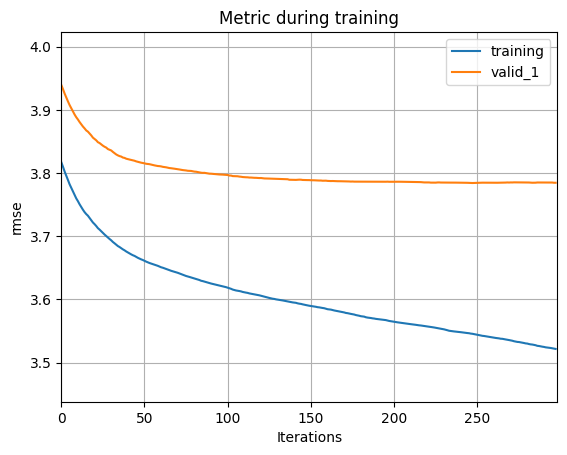

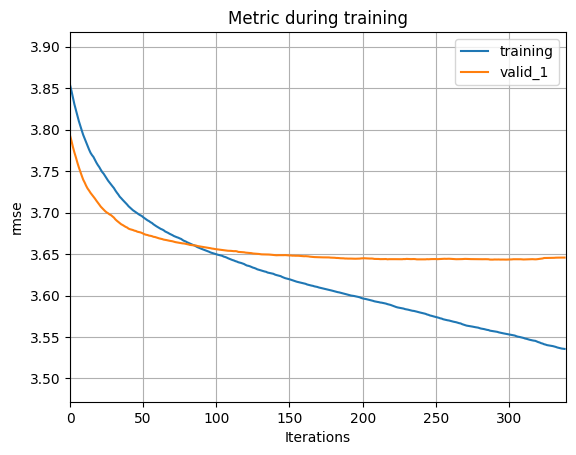

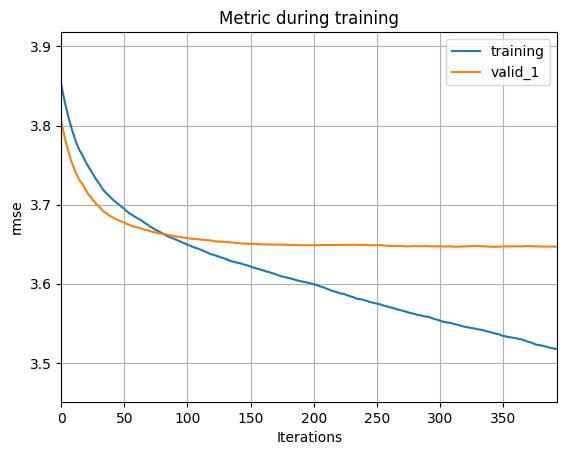

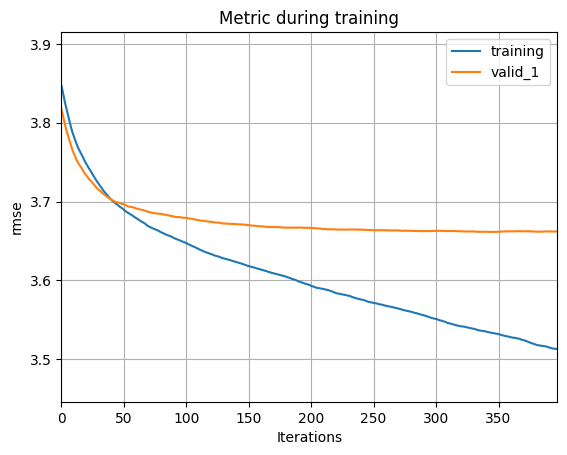

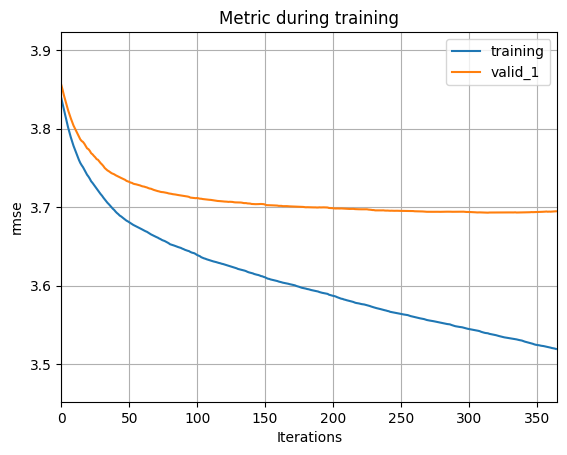

In [116]:
train_X = train_set[features]
test_X = test_set[features]
train_y = train_set[target_col].values
feature_importance = pd.DataFrame()

pred_test = 0
kf = model_selection.KFold(n_splits=5, random_state=2023, shuffle=True)
for fold_, (trn_index, val_index) in enumerate(kf.split(train_set)):
    trn_X, val_X = train_X.loc[trn_index,:], train_X.loc[val_index,:]
    trn_y, val_y = train_y[trn_index], train_y[val_index]
    
    pred_test_tmp, model, evals_result, feature_importance = run_lgb(fold_, trn_X, trn_y, val_X, val_y, test_X)
    pred_test += pred_test_tmp
    
pred_test /= 5.

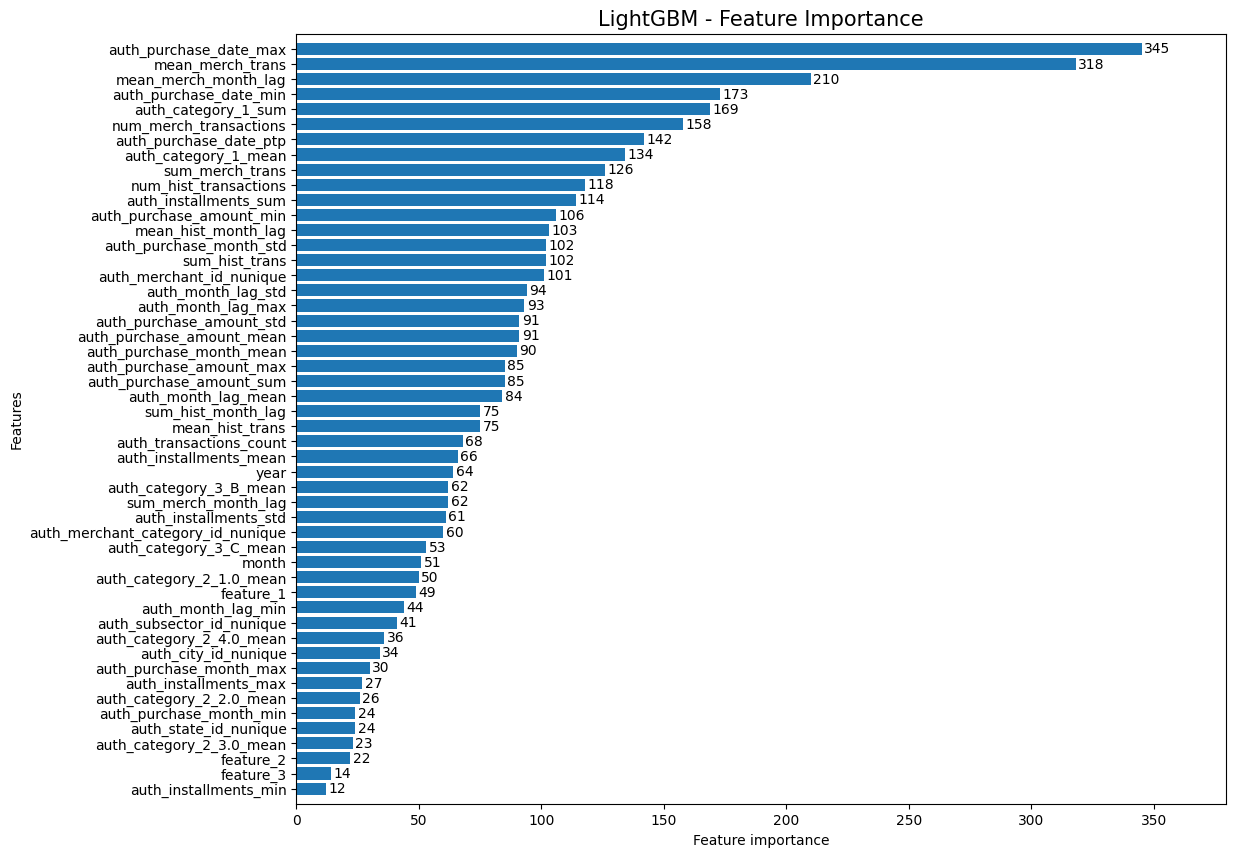

In [117]:
fig, ax = plt.subplots(figsize=(12,10))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

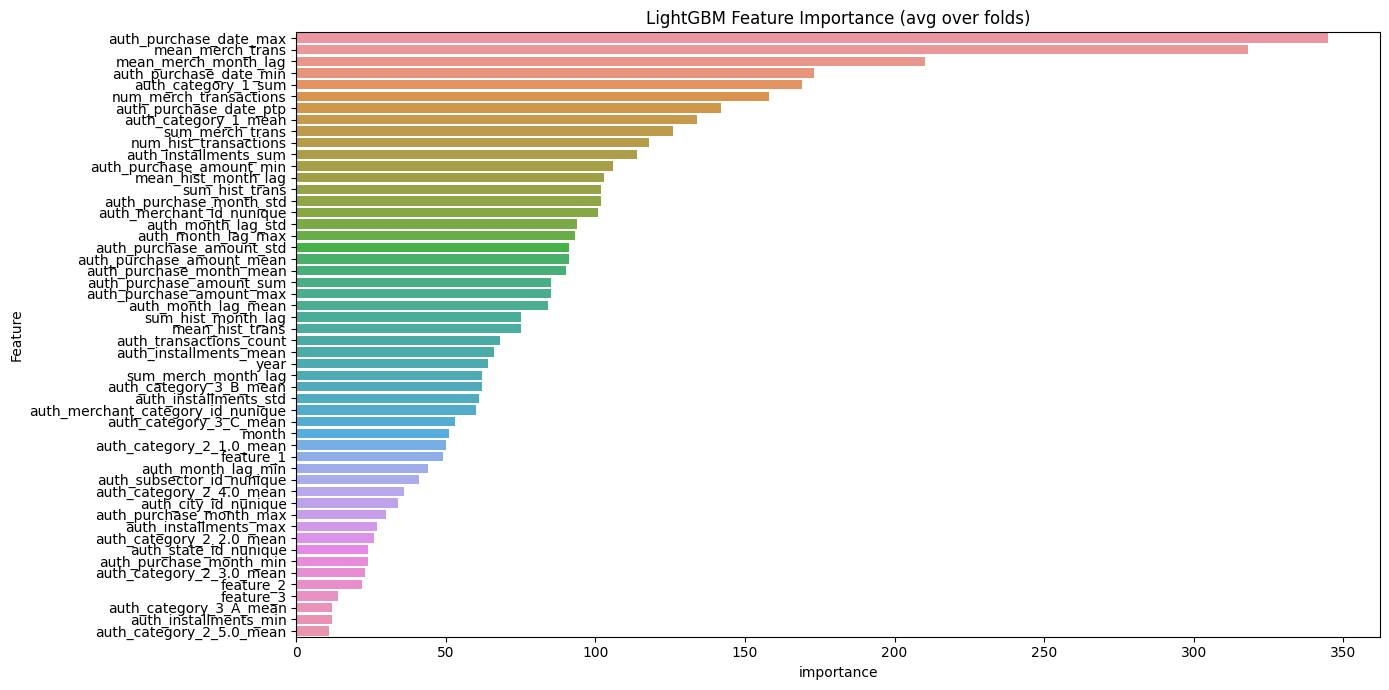

In [118]:
cols = (feature_importance[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False).index)

best_features = feature_importance.loc[feature_importance.Feature.isin(cols)]

plt.figure(figsize=(14,7))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Feature Importance (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [119]:
# Export to CSV file
import os 
sub_df = pd.DataFrame({"card_id" : test_set["card_id"].values})
sub_df["target"] = pred_test
sub_df.to_csv("submit.csv", index = False)